# MLOceanEnsemble with drifters for the Basin


### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "k"
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"

plt.rcParams["image.origin"] = "lower"

from importlib import reload

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress, DrifterPlotHelper, Observation
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL
from gpuocean.drifters import MLDrifterCollection, GPUDrifterCollection


In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

In [6]:
main_drifter_folder = 'drifter_data'
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
drifter_folder = os.path.join(main_drifter_folder, 'mldrifters_' + timestamp)
sl_drifter_folder = os.path.join(main_drifter_folder, 'sldrifters_' + timestamp)


## ML ensemble

In [7]:
ls = [6, 7, 8, 9]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [10]:
for l_idx in range(len(ls)):
    print(data_args_list[l_idx]['eta'][2:-2,2:-2].shape)

(128, 64)
(256, 128)
(512, 256)
(1024, 512)


In [11]:
spinup_end_time = 0
end_time = spinup_end_time + 900*5


In [12]:
#ML_Nes = [100, 75, 50, 25] # From Flo. Takes 1m24s to init, 3m13s to run to T=900
ML_Nes = [30, 20, 15, 10] # init: 34s, run: 1m36s


In [13]:
ML_ensemble = initMLensemble(ML_Nes, args_list, data_args_list, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)

0
1
2
3


In [14]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [15]:
reload(MultiLevelOceanEnsemble)
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [16]:
MLOceanEnsemble.stepToObservation(spinup_end_time)

In [17]:
drifter_ensemble_size = 30
num_drifters = 25
MLOceanEnsemble.attachDrifters(drifter_ensemble_size, num_drifters, drift_sensitivity=1)
sl_obs = []
for dsim in MLOceanEnsemble.ML_ensemble[2][0]:
    drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                          boundaryConditions=dsim.boundary_conditions,
                                                          domain_size_x=dsim.nx*dsim.dx, 
                                                          domain_size_y=dsim.ny*dsim.dy)
    dsim.attachDrifters(drifters)
    obs = Observation.Observation(nx=dsim.nx, ny=dsim.ny,
                                  domain_size_x=dsim.nx*dsim.dx, 
                                  domain_size_y=dsim.ny*dsim.dy)
    obs.add_observation_from_sim(dsim)
    sl_obs.append(obs)
    
init_positions = MLOceanEnsemble.drifters.getDrifterPositions()
init_pos_6  = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(6)
init_pos_11 = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(11)

print(drifter_folder)

drifter_data\mldrifters_2023_09_04-15_29_30


In [18]:
t = spinup_end_time
registration_frequency =  3*60
while t < end_time:
    tmp_end_time = t + registration_frequency
    MLOceanEnsemble.stepToObservation(tmp_end_time)
    MLOceanEnsemble.registerDrifterPositions()
    for sl_e in range(len(MLOceanEnsemble.ML_ensemble[2][0])):
        sl_obs[sl_e].add_observation_from_sim(MLOceanEnsemble.ML_ensemble[2][0][sl_e])

    t = t + registration_frequency


In [19]:
end_positions = MLOceanEnsemble.drifters.getDrifterPositions()
end_pos_6  = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(6)
end_pos_11 = MLOceanEnsemble.drifters.getDrifterPositionsForDrifter(11)


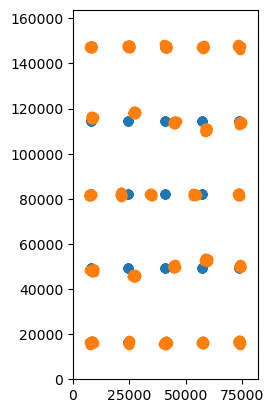

In [20]:

domain_size_x = MLOceanEnsemble.ML_ensemble[0][0].dx*MLOceanEnsemble.ML_ensemble[0][0].nx
domain_size_y = MLOceanEnsemble.ML_ensemble[0][0].dy*MLOceanEnsemble.ML_ensemble[0][0].ny
plt.scatter(init_positions[:, 0], init_positions[:, 1])
plt.xlim(0, domain_size_x)
plt.ylim(0, domain_size_y)
plt.gca().set_aspect('equal')
plt.scatter(end_positions[:, 0], end_positions[:, 1])
            

[[27632.43685518 45769.44744573]
 [26063.4318338  45797.22125162]
 [27209.9758954  45624.81891826]
 [27104.54620667 45913.05018429]
 [26952.81337948 45326.96050709]
 [27545.32238113 45201.17064677]
 [27524.28411857 45776.03180879]
 [27320.14341254 45317.20028041]
 [27541.28561493 46044.43552689]
 [26688.96373203 46252.13799346]
 [27203.75378432 46263.53728697]
 [26581.28018194 46521.14089053]
 [27351.90754916 46619.25432903]
 [27211.52244599 46184.2329184 ]
 [27050.43441683 46000.16114579]
 [27492.62578202 45760.16473512]
 [27707.44357286 45669.32031871]
 [28072.34088167 46147.15671543]
 [26991.9390332  45958.92526159]
 [26300.14127325 45958.21313968]
 [26884.48417392 45841.9609998 ]
 [27139.626712   46277.817611  ]
 [27390.1364072  46228.02495594]
 [27484.04886719 45758.28184439]
 [27083.37995569 45466.02490323]
 [27420.32840395 46033.29131913]
 [26492.97202648 45437.09822904]
 [27021.81673005 45326.74060619]
 [27748.10587876 45969.29522332]
 [26894.96846185 45882.97331788]]


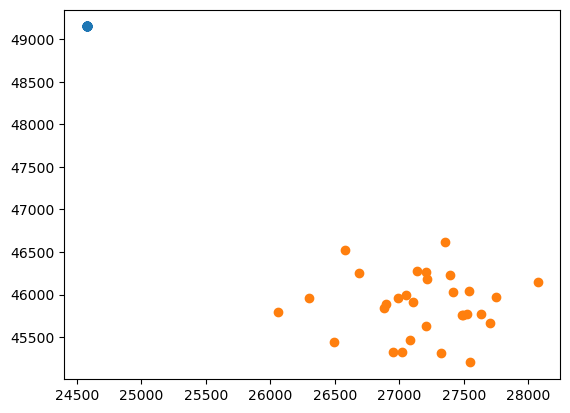

In [21]:

plt.scatter(init_pos_6[:, 0], init_pos_6[:, 1])
plt.scatter(end_pos_6[:, 0], end_pos_6[:, 1])
print(end_pos_6)
            

[[21524.67856797 81846.76094521]
 [21474.81095354 82966.49644908]
 [21403.45042736 82429.91759359]
 [21429.67959467 82123.24268761]
 [21490.11005682 83027.6212323 ]
 [21137.58024678 81603.29041775]
 [20924.46870179 81687.99161496]
 [21693.2226704  82288.82198327]
 [21479.31717353 81855.87125025]
 [21224.0776781  82499.22631003]
 [21339.37233209 82157.88528967]
 [21682.19047548 81333.03372058]
 [21389.60716571 81412.32363093]
 [20881.58647947 82733.27181328]
 [21205.93365633 81646.54555425]
 [20942.45443686 81815.03137753]
 [21461.89129574 80829.88044867]
 [21371.29546142 81663.79282939]
 [21327.46489238 81027.83147456]
 [21265.91861399 81293.995034  ]
 [21905.79997029 81414.93139658]
 [21591.16738327 81837.48826887]
 [21238.42834839 83177.24725285]
 [21213.43489533 81813.97083194]
 [21402.45621649 81409.30016722]
 [21117.30743148 81818.75351113]
 [21325.11287052 81488.53762262]
 [21312.59441006 82684.88913635]
 [21346.66190878 82101.20603032]
 [21529.50084044 81861.75407473]]


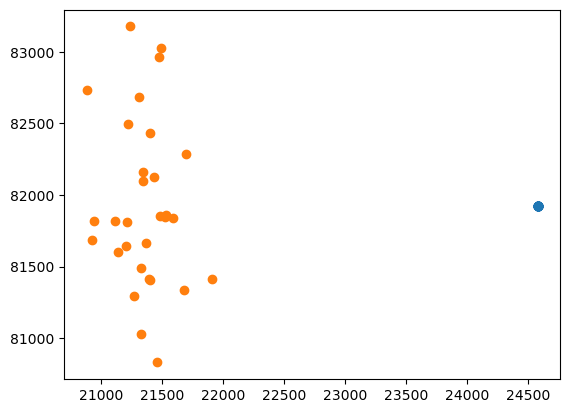

In [22]:

plt.scatter(init_pos_11[:, 0], init_pos_11[:, 1])
plt.scatter(end_pos_11[:, 0], end_pos_11[:, 1])
print(end_pos_11)
            

#### Save drifters to file
One file will contain one realization of every drifter, meaning that the there will be `drifter_ensemble_size` files, each with `num_drifters` drifters.

In [23]:
os.makedirs(drifter_folder)
MLOceanEnsemble.saveDriftTrajectoriesToFile(drifter_folder, "mldrifters")

In [24]:
os.makedirs(sl_drifter_folder)


### Plot the drifters

In [25]:
def readObservationFiles(folder):
    print(folder)
    obs_files = os.listdir(folder)
    print(obs_files)
    obs_files = list(file for file in obs_files if file.startswith("mldrifters"))
    print(obs_files)
    obs_files = list(file for file in obs_files if file.endswith(".bz2"))
    print(obs_files)
    obs_files = list(os.path.join(folder, file)  for file in obs_files)


    # Read observation files from the ensemble:
    assert(len(obs_files) == drifter_ensemble_size)
    ensemble_trajectories = [None]*len(obs_files)
    for i in range(len(obs_files)):
        ensemble_trajectories[i] = Observation.Observation(domain_size_x=domain_size_x, 
                                                        domain_size_y=domain_size_y, 
                                                        nx=MLOceanEnsemble.nxs[-1], ny=MLOceanEnsemble.nys[-1])
        ensemble_trajectories[i].read_pickle(obs_files[i])
        print("."+str(i)+".", end='')
    return ensemble_trajectories

ml_ensemble_trajectories = readObservationFiles(drifter_folder)
#sl_ensemble_trajectories = readObservationFiles(sl_drifter_folder)


drifter_data\mldrifters_2023_09_04-15_29_30
['mldrifters0000.bz2', 'mldrifters0001.bz2', 'mldrifters0002.bz2', 'mldrifters0003.bz2', 'mldrifters0004.bz2', 'mldrifters0005.bz2', 'mldrifters0006.bz2', 'mldrifters0007.bz2', 'mldrifters0008.bz2', 'mldrifters0009.bz2', 'mldrifters0010.bz2', 'mldrifters0011.bz2', 'mldrifters0012.bz2', 'mldrifters0013.bz2', 'mldrifters0014.bz2', 'mldrifters0015.bz2', 'mldrifters0016.bz2', 'mldrifters0017.bz2', 'mldrifters0018.bz2', 'mldrifters0019.bz2', 'mldrifters0020.bz2', 'mldrifters0021.bz2', 'mldrifters0022.bz2', 'mldrifters0023.bz2', 'mldrifters0024.bz2', 'mldrifters0025.bz2', 'mldrifters0026.bz2', 'mldrifters0027.bz2', 'mldrifters0028.bz2', 'mldrifters0029.bz2']
['mldrifters0000.bz2', 'mldrifters0001.bz2', 'mldrifters0002.bz2', 'mldrifters0003.bz2', 'mldrifters0004.bz2', 'mldrifters0005.bz2', 'mldrifters0006.bz2', 'mldrifters0007.bz2', 'mldrifters0008.bz2', 'mldrifters0009.bz2', 'mldrifters0010.bz2', 'mldrifters0011.bz2', 'mldrifters0012.bz2', 'mldrift

#### Plot all drifters from the first (drifter) ensemble member

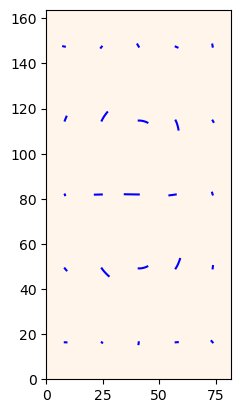

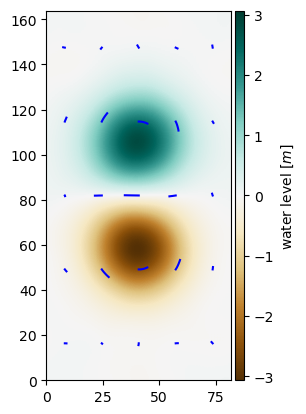

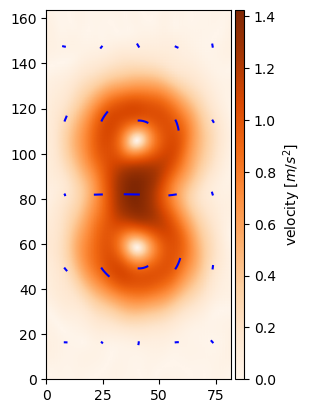

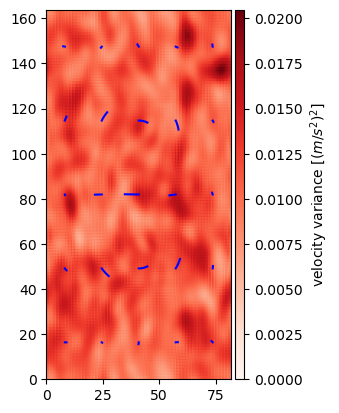

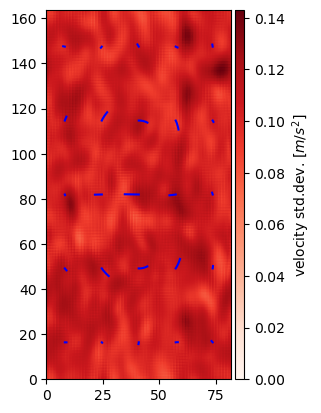

In [26]:
reload(DrifterPlotHelper)
for background in ["landmask", "eta", "velocity", "velocity_variance", "velocity_stddev"]:
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble, background_type=background)
    for i in range(num_drifters):
        DrifterPlotHelper.add_drifter_on_background(ax, ml_ensemble_trajectories[0], drifter_id=i)


#### Plot all realizations of a given drifter

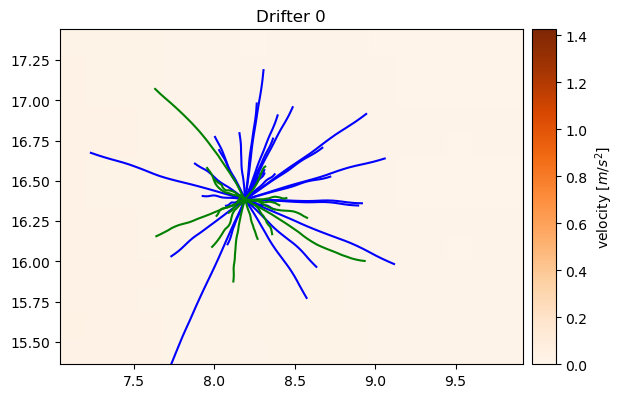

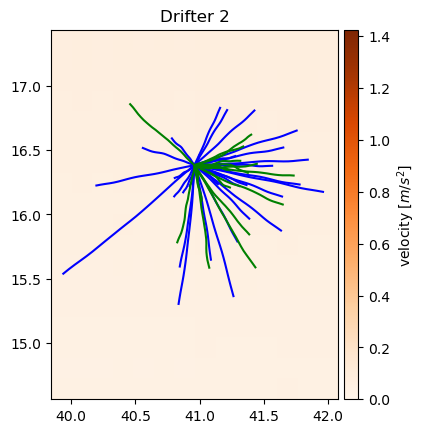

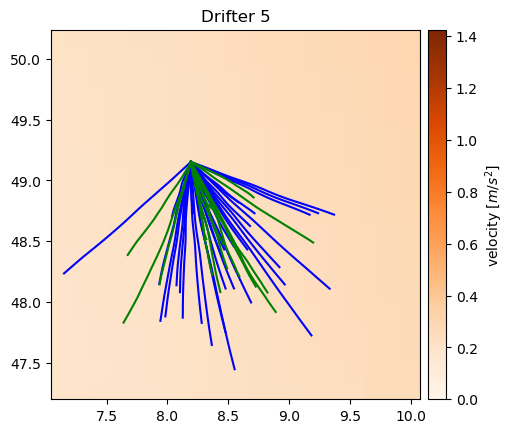

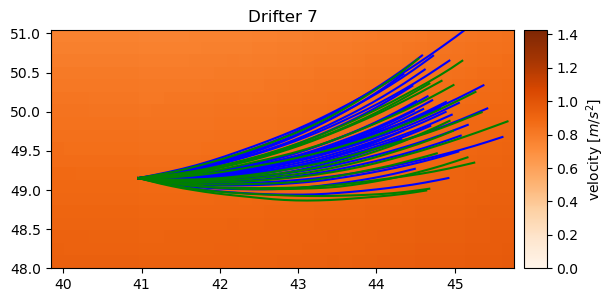

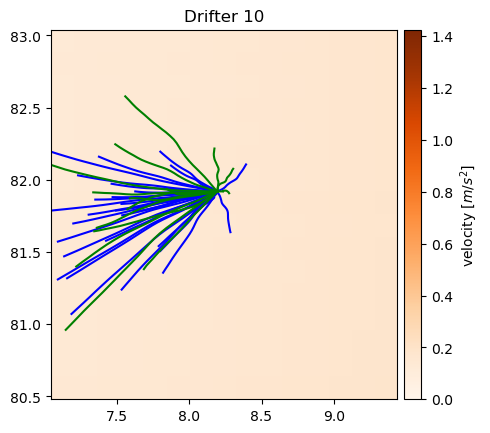

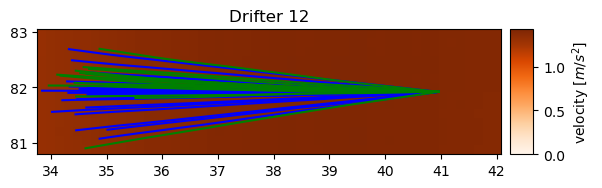

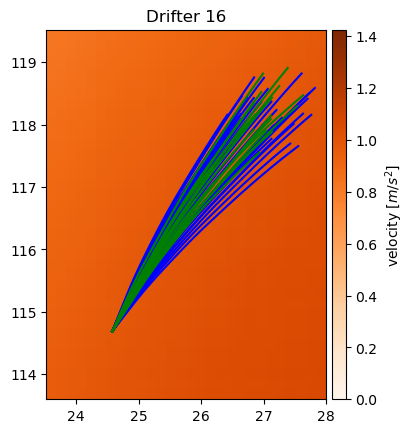

In [27]:

for drifter_id in [0, 2, 5, 7, 10, 12, 16]:
    drifter_domain = DrifterPlotHelper.domain_around_drifter(ml_ensemble_trajectories[0], drifter_id=drifter_id, padding_in_km=1)
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble, background_type="velocity", drifter_domain=drifter_domain)
    ax.set_title("Drifter "+str(drifter_id))
    for i in range(drifter_ensemble_size):
        DrifterPlotHelper.add_drifter_on_background(ax, ml_ensemble_trajectories[i], drifter_id=drifter_id)
    for obs in sl_obs:
        DrifterPlotHelper.add_drifter_on_background(ax, obs, drifter_id=drifter_id, color='Green')
    
